# Metric Learning

- Many algorithms rely on measuring similarity or distance between data points.
- Common similarity metrics:  
  - **Euclidean distance** (straight-line distance)  
  - **Cosine similarity** (angle-based similarity)
- These standard metrics are simple but **not always optimal** for every dataset.
- **Metric learning** is the process of learning a better distance measure **tailored to your data**.
- This improves performance of algorithms like:  
  - k-means clustering  
  - k-Nearest Neighbors (kNN) classification

---



## Why Learn a Metric?

- Imagine two data points representing images of cats and dogs.
- Euclidean distance treats all features equally — but some features might be more important.
- Metric learning adjusts the "importance" of features automatically.
- Result: Similar items are closer; dissimilar items are farther apart in the learned space.

---



## Recap: Euclidean Distance

Between two vectors $x$ and $x'$:

$$
d(x, x') = \sqrt{\sum_{i=1}^D (x_i - x'_i)^2} = \sqrt{(x - x')^\top (x - x')}
$$

- Measures the straight-line distance in $D$ - dimensional space.
- Treats each feature dimension equally.

---

In [16]:
import torch

# Example vectors
x = torch.tensor([1.0, 2.0, 3.0])
x_prime = torch.tensor([2.0, 4.0, 6.0])

# Euclidean distance
def euclidean_distance(a, b):
    return torch.norm(a - b, p=2)

print("Euclidean distance:", euclidean_distance(x, x_prime).item())

Euclidean distance: 3.7416574954986572


## Parametrizing the Distance Metric with Matrix $A$

Modify the distance formula to:

$$
d_A(x, x') = \sqrt{(x - x')^\top A (x - x')}
$$

- $A$ is a $D \times D$ matrix controlling feature importance and correlations.
- If $A = I$ (identity matrix), this reduces to Euclidean distance.
- If $A$ is diagonal with different values, each feature is weighted differently.

---

In [17]:
# Initialize matrix A (D x D), here with requires_grad=True to learn it
D = 3
A = torch.eye(D, requires_grad=True)  # Start with identity matrix

def parametrized_distance(a, b, A):
    diff = (a - b).unsqueeze(0)  # shape (1, D)
    dist_sq = diff @ A @ diff.t()  # scalar inside a 1x1 tensor
    return torch.sqrt(dist_sq.squeeze())

print("Parametrized distance (A=I):", parametrized_distance(x, x_prime, A).item())


Parametrized distance (A=I): 3.7416574954986572


## Example of Weighted Features

Consider $D=3$ and:

$$
A = \begin{bmatrix}
2 & 0 & 0 \\
0 & 8 & 0 \\
0 & 0 & 1
\end{bmatrix}
$$

- The second feature dimension contributes the most to the distance.
- Features with higher weights have greater influence on similarity.

---

In [18]:
A_weighted = torch.diag(torch.tensor([2.0, 8.0, 1.0]))
print("Weighted distance:", parametrized_distance(x, x_prime, A_weighted).item())


Weighted distance: 6.557438373565674


## What Makes a Valid Metric?

A function $d(x, x')$ is a **metric** if it satisfies:

1. **Non-negativity:** $d(x, x') \geq 0$  
2. **Triangle inequality:** $d(x, x') \leq d(x, z) + d(z, x')$ for any $z$  
3. **Symmetry:** $d(x, x') = d(x', x)$

---

## Positive Semidefinite (PSD) Matrix $A$

- To satisfy conditions 1 and 2, $A$ must be **positive semidefinite (PSD)**.
- Intuition: PSD matrices generalize the idea of nonnegative numbers to matrices.
- For any vector $z$:

$$
z^\top A z \geq 0
$$

- This ensures distances are always nonnegative and the triangle inequality holds.

---

## Ensuring Symmetry

- If the distance formula is not symmetric, we can symmetrize it by:

$$
d_{sym}(x, x') = \frac{d_A(x, x') + d_A(x', x)}{2}
$$

---

## Preparing Training Data for Metric Learning

- Start with an unlabelled dataset $X = \{x_i\}$.
- Define two sets of pairs:
  - $S$ : pairs $(x_i, x_j)$ that are **similar** (e.g., same class)
  - $D$ : pairs $(x_i, x_j)$ that are **dissimilar** (e.g., different classes)
- These sets act as **constraints** for learning the metric.

---

## The Optimization Objective

Find $A$ that:

- Minimizes distances for similar pairs:

$$
\min_A \sum_{(x_i, x_j) \in S} d_A(x_i, x_j)^2
$$

- While keeping distances for dissimilar pairs above a margin $c$ :

$$
\text{subject to } \sum_{(x_i, x_j) \in D} d_A(x_i, x_j)^2 \geq c
$$

- $A$ must remain PSD during optimization.

---

## How is $A$ Learned?

- Use **gradient descent** with projections to ensure $A$ stays PSD.
- This involves iteratively updating $A$ to better separate similar and dissimilar pairs.

Many advanced methods exist (nonlinear, kernelized metric learning).

 This linear approach is a solid starting point for practical problems.

---

In [19]:
# Toy dataset with feature vectors (4 points in 3D)
X = torch.tensor([
    [1., 2., 3.],
    [1., 2., 2.9],
    [5., 5., 5.],
    [5., 5.1, 5.]
])

# Similar pairs (indices)
similar_pairs = [(0,1), (2,3)]
# Dissimilar pairs (indices)
dissimilar_pairs = [(0,2), (1,3)]

# Initialize A as a PSD matrix via A = L^T L
L = torch.eye(D, requires_grad=True)  # lower triangular factor

optimizer = torch.optim.Adam([L], lr=0.1)
margin = 1.0

def dist_L(a, b, L):
    diff = (a - b).unsqueeze(0)
    A = L.t() @ L
    dist_sq = diff @ A @ diff.t()
    return torch.sqrt(dist_sq.squeeze())

for epoch in range(100):
    optimizer.zero_grad()
    A = L.t() @ L

    # Loss to pull similar pairs close
    loss_sim = torch.stack([dist_L(X[i], X[j], L)**2 for (i,j) in similar_pairs]).sum()
    # Loss to push dissimilar pairs apart (hinge loss)
    loss_dissim = torch.stack([
        torch.relu(margin - dist_L(X[i], X[j], L))**2 for (i,j) in dissimilar_pairs
    ]).sum()

    loss = loss_sim + loss_dissim
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.4f}")


Epoch 0: Loss = 0.0200
Epoch 20: Loss = 0.0015
Epoch 40: Loss = 0.0002
Epoch 60: Loss = 0.0000
Epoch 80: Loss = 0.0000


## Intuition Recap

- Metric learning **reshapes the space** so that "similar" points are closer.
- It assigns **importance weights** to features via $A$ .
- Learning $A$ is a form of supervised learning guided by similarity/dissimilarity constraints.

---


# Learning to Rank

A supervised learning technique used to rank documents based on relevance, often applied in search engines.

**Goal :**
- Learn a function $f$ that outputs scores
- These scores induce a ranking similar to human-labeled ranks

---



## Training Data Format

Each training example $X_i$ contains ranked documents:

$$
X_i = \{ (x_{i,j}, y_{i,j}) \}_{j=1}^{r_i}
$$

- $x_{i,j}$ : feature vector for doc j
- $y_{i,j}$ : rank or score

**Feature examples:** Recency, Query match in title, Document length, etc.

---



## Pointwise Approach

- Convert each document to $(x, y)$
- Use regression or classification

 **Limitation:** Ignores document interactions

---


In [20]:
## PyTorch Code: Pointwise Ranking

import torch
import torch.nn as nn

class RankRegressor(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x)

# Sample document features and scores
X = torch.randn(10, 5)  # 10 docs, 5 features each
y = torch.rand(10, 1)   # relevance score

model = RankRegressor(input_dim=5)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

output = model(X)
loss = loss_fn(output, y)
loss.backward()
optimizer.step()



---

## Pairwise Approach

- Train on pairs: $(x_i, x_k)$
- Learn preference: $f(x_i, x_k) \approx 1$ if $x_i \succ x_k$

Final ranking = Aggregate all pairwise preferences

---


In [21]:

## PyTorch Code: Pairwise Ranking

def pairwise_loss(h_i, h_j):
    margin = 1.0
    return torch.clamp(margin - (h_i - h_j), min=0).mean()

h = model(X).squeeze()
pairs = [(0, 1), (2, 3), (4, 5)]  # doc i ranked higher than j

loss = sum(pairwise_loss(h[i], h[j]) for i, j in pairs)
loss.backward()
optimizer.step()



## Listwise Approach

- Optimize directly for a ranking metric (e.g., MAP)
- **Input:** whole list of docs per query
- **Output:** scores that yield best listwise ranking

 Used in state-of-the-art methods like **LambdaMART**

---



## MAP (Mean Average Precision)

- Measures ranking quality based on relevance

$$
\text{AveP}(q) = \frac{1}{|R|} \sum_{k=1}^{n} P(k) \cdot rel(k)
$$

$$
\text{MAP} = \frac{1}{Q} \sum_{q=1}^{Q} \text{AveP}(q)
$$

- $P(k)$ : Precision at top-k
- $rel(k)$: 1 if relevant at rank k, 0 otherwise

---



## LambdaMART (Gradient Boosted Ranking)

- Uses trees to model ranking function \( h(x) \)
- Pairwise function:

$$
f(x_i, x_k) = \frac{1}{1 + \exp((h(x_k) - h(x_i)) \cdot \sigma)}
$$

- **Loss:** Cross-entropy on these pairwise comparisons
- Gradient is modified to directly optimize MAP

---



## LambdaMART Key Idea

- Replace true gradient with a metric-aware gradient

- Boosting adds trees to reduce metric error
- Direct optimization of MAP, not just cost function

- One of the few methods optimizing *what we actually care about*

---



## Sorting from Pairwise Scores

To convert pairwise predictions into a ranking:
- Use any sorting algorithm (e.g. Bubble Sort)
- Replace numeric comparison with $f(x_i, x_j)$

```python
def compare_docs(i, j):
    return f[i][j] > 0.5  # f(i ranked higher than j)

ranking = sorted(range(len(docs)), key=lambda i: scores[i], reverse=True)
```

You can use `scikit-learn`, `XGBoost`, or `LightGBM` for LambdaMART implementations.

---



# Learning to Recommend

- Learning to Recommend builds **recommender systems**.
- **Goal:** Suggest content (e.g., movies, books) to users based on their past behavior.

Two classic methods:
- **Content-based filtering**
- **Collaborative filtering**

---



## Content-Based Filtering

- Learns user preferences from features of the content they consumed.
- Example features: topic, author, price, recency.

```python
# Content-based example using scikit-learn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X = ...  # Feature vectors (e.g., TF-IDF vectors of articles)
y = ...  # Labels (1 if user read the article, 0 otherwise)

model = LogisticRegression()
model.fit(X, y)
```

---



## Problems with Content-Based Filtering

- Users get trapped in a **filter bubble**.
- Recommendations lack diversity.
- Recommends things user may already know.

---



## Collaborative Filtering

- Based on user-item interactions
- Uses other users' preferences to recommend new items.

**Data structure:** sparse **user-item matrix**.

```python
import numpy as np

# Sparse user-item matrix (5 users x 6 items)
ratings = np.array([
    [5, 0, 0, 1, 0, 0],
    [4, 0, 0, 1, 0, 0],
    [1, 1, 0, 5, 0, 0],
    [1, 0, 0, 4, 0, 0],
    [0, 1, 5, 4, 0, 0],])

```

---



## Two algorithms to do it : -

## Factorization Machines (FM)

- Designed for sparse data.
- Models feature interactions without exploding parameter size.

FM Model:
$$
f(x) = b + \sum w_i x_i + \sum_{i=1}^{D} \sum_{j=i+1}^{D} \langle v_i, v_j \rangle x_i x_j
$$

---



### FM in PyTorch (Basic Idea)

```python
import torch
import torch.nn as nn

class FactorizationMachine(nn.Module):
    def __init__(self, n_features, k):
        super().__init__()
        self.linear = nn.Linear(n_features, 1)
        self.v = nn.Parameter(torch.randn(n_features, k))

    def forward(self, x):
        linear_term = self.linear(x)
        interactions = 0.5 * torch.sum(
            (x @ self.v) ** 2 - (x ** 2) @ (self.v ** 2), dim=1, keepdim=True)
        return linear_term + interactions
```

---



### Loss Function for FM

- For binary classification:
$$
\text{loss}(f(x), y) = \log(1 + e^{-yf(x)}) / \log(2)
$$
- Optimized via stochastic gradient descent.

---



## Denoising Autoencoders (DAE)

- Input = user’s past behavior (with random corruption)
- Output = reconstruct full user behavior
- Ideal for recommendation via **input reconstruction**

---


In [22]:
## DAE in PyTorch

class DAE(nn.Module):
    def __init__(self, n_inputs):
        super().__init__()
        self.encoder = nn.Linear(n_inputs, 128)
        self.decoder = nn.Linear(128, n_inputs)

    def forward(self, x):
        h = torch.relu(self.encoder(x))
        return torch.sigmoid(self.decoder(h))

# Simulate input corruption
x = torch.FloatTensor([[1, 0, 0, 1, 1]])
x_corrupt = x.clone()
x_corrupt[0,1] = 0
model = DAE(n_inputs=5)
pred = model(x_corrupt)


---

### Recommend from DAE Output

```python
# Recommend items with highest scores in pred not already seen in x
scores = pred.detach().numpy().flatten()
recommend_idx = [i for i in np.argsort(-scores) if x[0,i] == 0]
print("Recommend item indices:", recommend_idx[:3])
```

---



## Feed-Forward Neural Network for Recommendation

- Input: (user one-hot, item one-hot)
- Output: rating prediction

```python
class RecNN(nn.Module):
    def __init__(self, n_users, n_items):
        super().__init__()
        self.user_embed = nn.Embedding(n_users, 32)
        self.item_embed = nn.Embedding(n_items, 32)
        self.fc = nn.Sequential(
            nn.Linear(64, 128), nn.ReLU(), nn.Linear(128, 1)
        )

    def forward(self, user_id, item_id):
        u = self.user_embed(user_id)
        i = self.item_embed(item_id)
        x = torch.cat([u, i], dim=1)
        return self.fc(x)
```
---



# Self-Supervised Learning :
## Word Embeddings

- Word embeddings are **vector representations** of words.
- They capture **semantic meaning**: similar words ≈ similar vectors.
- Trained in a self-supervised way: the model learns from **unlabeled data**.
- One popular method: **Word2Vec (Skip-Gram)**.

---



## Skip-Gram Intuition

- **Goal:** predict **context words** from a **center word**.
- Example (window=2):  
  **Sentence:** *"I love learning machine learning"*  
  **Skip-gram pairs:**  
  - ('love', 'I'), ('love', 'learning')  
  - ('learning', 'love'), ('learning', 'machine')

---



##  Skip-Gram Code with PyTorch (Toy Example)


In [23]:

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Sample toy corpus
corpus = "I love machine learning and I love deep learning"

# Preprocessing
words = corpus.lower().split()
vocab = list(set(words))
word2idx = {w: idx for idx, w in enumerate(vocab)}
idx2word = {idx: w for w, idx in word2idx.items()}
vocab_size = len(vocab)

# Create Skip-gram pairs (window=1)
def create_skipgrams(words, window_size=1):
    pairs = []
    for i in range(window_size, len(words) - window_size):
        target = words[i]
        context = [words[i - j] for j in range(1, window_size + 1)]
        context += [words[i + j] for j in range(1, window_size + 1)]
        for ctx_word in context:
            pairs.append((target, ctx_word))
    return pairs

pairs = create_skipgrams(words)

# Convert to indices
X_train = torch.tensor([word2idx[p[0]] for p in pairs])
Y_train = torch.tensor([word2idx[p[1]] for p in pairs])

# Model
class Word2Vec(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.output = nn.Linear(embed_dim, vocab_size)
    
    def forward(self, x):
        emb = self.embedding(x)
        out = self.output(emb)
        return out

model = Word2Vec(vocab_size, embed_dim=10)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
for epoch in range(500):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = loss_fn(output, Y_train)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")


Epoch 0, Loss: 1.8702


Epoch 100, Loss: 0.8057
Epoch 200, Loss: 0.7957
Epoch 300, Loss: 0.7938
Epoch 400, Loss: 0.7932


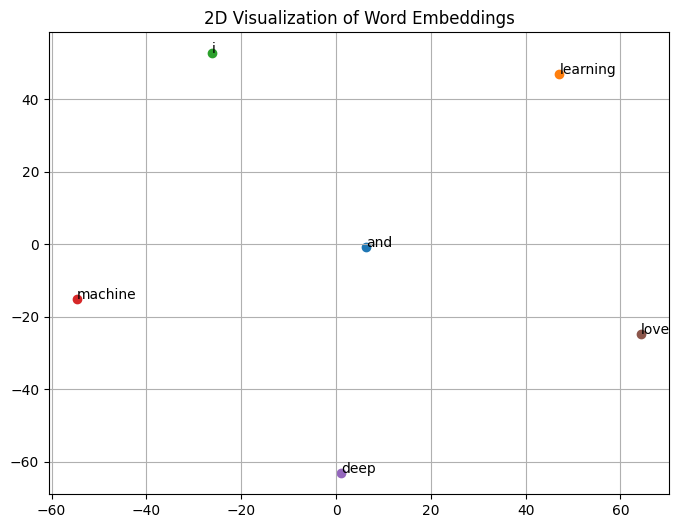

In [24]:

#  Visualizing Word Embeddings (after training)

# Get embeddings
embeddings = model.embedding.weight.data.detach().numpy()

# Reduce to 2D for plotting
n_samples = embeddings.shape[0]
adjusted_perplexity = min(30, n_samples - 1)  # or even n_samples // 3

tsne = TSNE(n_components=2, perplexity=adjusted_perplexity, random_state=42)
reduced = tsne.fit_transform(embeddings)

# Plot
plt.figure(figsize=(8, 6))
for i, label in enumerate(vocab):
    x, y = reduced[i]
    plt.scatter(x, y)
    plt.text(x + 0.01, y + 0.01, label)
plt.title("2D Visualization of Word Embeddings")
plt.grid(True)
plt.show()
